<a href="https://colab.research.google.com/github/Archangelphrank/BNF-5507-Materials/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# General
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Survival Models
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

# Modeling
from sklearn.model_selection import train_test_split

In [5]:
%pip install lifelines scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=06acaf044e78753bd1266d853599a0eb1875447d3e2e74a182228dd1041c62ef
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1

In [14]:
df = pd.read_excel("/RADCURE_Clinical_v04_20241219.xlsx")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         3346 non-null   object        
 1   Age                3346 non-null   float64       
 2   Sex                3346 non-null   object        
 3   ECOG PS            3345 non-null   object        
 4   Smoking PY         3341 non-null   object        
 5   Smoking Status     3346 non-null   object        
 6   Ds Site            3346 non-null   object        
 7   Subsite            2972 non-null   object        
 8   T                  3334 non-null   object        
 9   N                  3333 non-null   object        
 10  M                  3332 non-null   object        
 11  Stage              3319 non-null   object        
 12  Path               3346 non-null   object        
 13  HPV                1717 non-null   object        
 14  Tx Modal

In [75]:
# Copy for processing

df_clean =df.copy()
df_clean.columns = df_clean.columns.str.strip()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         3346 non-null   object        
 1   Age                3346 non-null   float64       
 2   Sex                3346 non-null   object        
 3   ECOG PS            3345 non-null   object        
 4   Smoking PY         3341 non-null   object        
 5   Smoking Status     3346 non-null   object        
 6   Ds Site            3346 non-null   object        
 7   Subsite            2972 non-null   object        
 8   T                  3334 non-null   object        
 9   N                  3333 non-null   object        
 10  M                  3332 non-null   object        
 11  Stage              3319 non-null   object        
 12  Path               3346 non-null   object        
 13  HPV                1717 non-null   object        
 14  Tx Modal

In [76]:
print(df_clean.columns.tolist())

['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Ds Site', 'Subsite', 'T', 'N', 'M', 'Stage', 'Path', 'HPV', 'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status', 'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local', 'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca', 'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced']


In [79]:
# Define event column from Status
df_clean["event"] = df_clean["Status"].str.lower().eq("dead").astype(int)
# Check event distribution
df_clean["event"].value_counts()

,count
event,
0,2288
1,1058


In [81]:
df_clean["time"] = np.where(
    df_clean["event"] == 1,
    (df_clean["Date of Death"] - df_clean["RT Start"]).dt.days,
    (df_clean["Last FU"] - df_clean["RT Start"]).dt.days
)

# Confirm it's there
df_clean[["time", "event", "Age", "Sex", "ECOG PS", "Smoking PY"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        3346 non-null   float64
 1   event       3346 non-null   int64  
 2   Age         3346 non-null   float64
 3   Sex         3346 non-null   object 
 4   ECOG PS     3345 non-null   object 
 5   Smoking PY  3341 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 157.0+ KB


In [82]:
df_clean.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
patient_id,3346,3346,RADCURE-4130,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,3346.0,NaN,NaN,NaN,62.300418,15.6,54.5,62.1,70.3,90.0,11.645892
Sex,3346,2,Male,2660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECOG PS,3345,10,ECOG 0,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smoking PY,3341.0,100.0,0.0,871.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smoking Status,3346,4,Ex-smoker,1290,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ds Site,3346,19,Oropharynx,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subsite,2972,63,Glottis,630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,3334,17,T2,927,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N,3333,10,N0,1147,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Check missing values
df_clean[["time", "event", "Age", "Sex", "ECOG PS", "Smoking PY"]].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        3346 non-null   float64
 1   event       3346 non-null   int64  
 2   Age         3346 non-null   float64
 3   Sex         3346 non-null   object 
 4   ECOG PS     3345 non-null   object 
 5   Smoking PY  3341 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 157.0+ KB


In [84]:
print("Sex:", df_clean["Sex"].unique())
print("ECOG PS:", df_clean["ECOG PS"].unique())
print("Smoking PY:", df_clean["Smoking PY"].unique())

Sex: ['Female' 'Male']
ECOG PS: ['ECOG 0' 'ECOG 2' 'ECOG 1' 'Unknown' 'ECOG 4' 'ECOG 3' 'ECOG-Pt 2' nan
 'ECOG 0-1' 'ECOG-Pt 0' 'ECOG-Pt 1']
Smoking PY: [50 25 15 30 0 55 5 8 20 40 22 35 10 60 2 100 49 67.5 65 45 1 90 80 7 17
 52 46 '>50' 'na' 43 16 4 3 7.5 37 18 21 32 34 '>20' 47 70 19 14 33 75 0.5
 9 6 17.5 0.3 240 27.5 78 23 12.5 42 36 150 12 '<20' 74 38 1.5 64 2.5 53
 '<10' 11 24 nan 44 '>25' 120 110 67 48 62 26 13 13.5 39 115 27 28 135
 22.5 57 '<5' 86 31 8.5 118 105 108 66 54 37.5 41 56 20.3]


In [92]:
# Encode Sex using original values from df
df_clean["Sex"] = df["Sex"].map({"Female": 0, "Male": 1})
print(df_clean["Sex"].unique())

[0 1]


In [85]:
df_clean["ECOG_cleaned"] = (
    df_clean["ECOG PS"]
    .str.extract(r"(\d)")
    .astype(float)
)

In [86]:
def clean_smoking_py(x):
    try:
        return float(x)
    except:
        if isinstance(x, str):
            x = x.strip()
            if x.startswith(">") or x.startswith("<"):
                return float(x[1:])  # keep numeric estimate
            elif x.lower() in ["na", "unknown"]:
                return None
        return None

df_clean["Smoking_cleaned"] = df_clean["Smoking PY"].apply(clean_smoking_py)

In [94]:
#Drop rows with any missing values for modeling variables
model_vars = ["time", "event", "Age", "Sex", "ECOG_cleaned", "Smoking_cleaned"]
df_clean = df_clean[model_vars].dropna().reset_index(drop=True)

In [100]:
#df_clean.head()
#df_clean.isna().sum()
#df_clean.info()
#print("Sex values:\n", df_clean["Sex"].value_counts())
#print("ECOG_cleaned:\n", df_clean["ECOG_cleaned"].value_counts().sort_index())

Sex values:
 Sex
1    2613
0     653
Name: count, dtype: int64
ECOG_cleaned:
 ECOG_cleaned
0.0    2001
1.0    1011
2.0     208
3.0      40
4.0       6
Name: count, dtype: int64


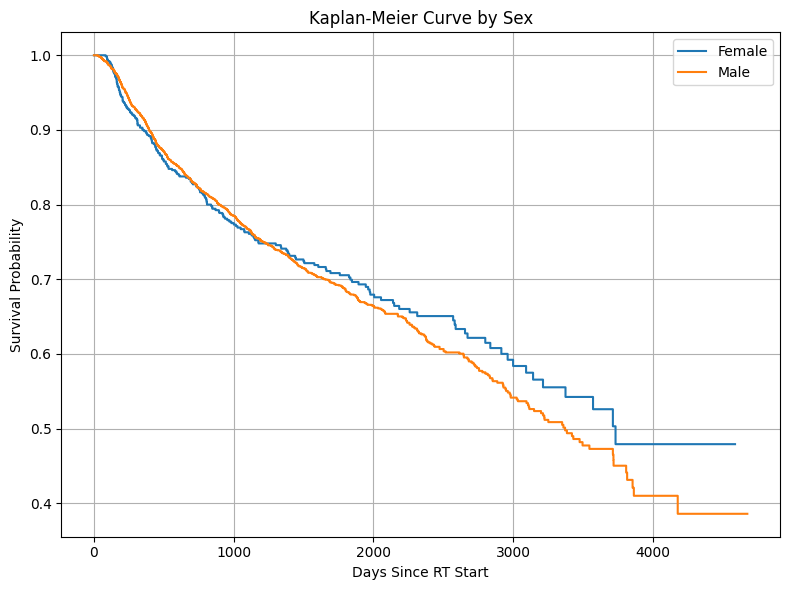

In [114]:
# Split by sex (0 = Female, 1 = Male)
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for label in [0, 1]:
    mask = df_clean["Sex"] == label
    label_name = "Female" if label == 0 else "Male"
    kmf.fit(durations=df_clean[mask]["time"], event_observed=df_clean[mask]["event"], label=label_name)
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Curve by Sex")
plt.xlabel("Days Since RT Start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [109]:
#Log-Rank Test (Sex)
group_female = df_clean[df_clean["Sex"] == 0]
group_male = df_clean[df_clean["Sex"] == 1]

results = logrank_test(
    durations_A=group_female["time"],
    durations_B=group_male["time"],
    event_observed_A=group_female["event"],
    event_observed_B=group_male["event"]
)

print("Log-Rank Test p-value:", round(results.p_value, 4))

Log-Rank Test p-value: 0.4238


In [105]:
# Bin ECOG into 3 categories
df_clean["ECOG_group"] = pd.cut(
    df_clean["ECOG_cleaned"],
    bins=[-1, 0, 2, 5],
    labels=["ECOG 0", "ECOG 1–2", "ECOG ≥3"]
)

# Subset valid rows
ecog_data = df_clean.dropna(subset=["ECOG_group"])

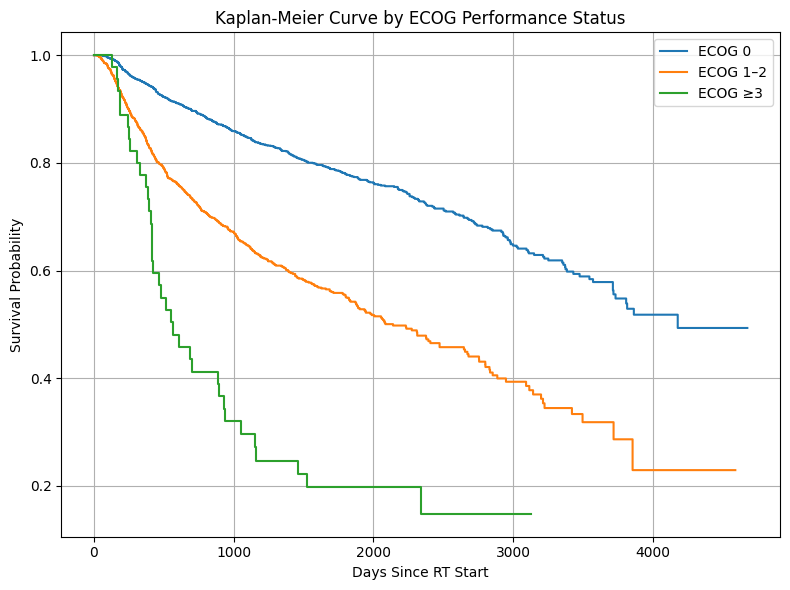

In [113]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for group in ecog_data["ECOG_group"].unique():
    mask = ecog_data["ECOG_group"] == group
    kmf.fit(ecog_data[mask]["time"], ecog_data[mask]["event"], label=str(group))
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Curve by ECOG Performance Status")
plt.xlabel("Days Since RT Start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
#Log-Rank Test for ECOG groups
from lifelines.statistics import multivariate_logrank_test

results = multivariate_logrank_test(
    ecog_data["time"],
    ecog_data["ECOG_group"],
    ecog_data["event"]
)

results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         281.01 <0.005    202.71

In [116]:
from lifelines import CoxPHFitter

# Instantiate and fit the Cox model
cph = CoxPHFitter()
cph.fit(df_clean[["time", "event", "Age", "Sex", "ECOG_cleaned"]], duration_col="time", event_col="event")

# Show model summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3266 total observations, 2241 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3266
number of events observed = 1025
   partial log-likelihood = -7489.18
         time fit was run = 2025-07-01 02:00:02 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Age           0.04      1.04      0.00            0.03            0.04                1.03                1.04
Sex           0.07      1.07      0.08           -0.08            0.23                0.92                1.26
ECOG_cleaned  0.57      1.76      0.04            0.49            0.64                1.64                1.90

              cmp to     z      p  -log2(p)
covariate                                  
Age             0.00 12.72 <0.005    120.64
Sex             0.00  0.91   0.36      1.46
ECOG_cleaned    0.00 15.04 <0.005    167.48
---
Concordance = 0.68
Partial AIC = 14984.36
log-likelihood ratio test = 424.49 on 3 df
-log2(p) of ll-ratio test = 302.16


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3266 total observations, 2241 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
Age          km             28.91 <0.005     23.65
             rank           25.05 <0.005     20.77
ECOG_cleaned km              6.31   0.01      6.38
             rank            5.94   0.01      6.08
Sex          km              4.12   0.04      4.56
             rank            4.52   0.03      4.90



1. Variable 'Age' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Sex' failed the non-proportional test: p-value is 0.0335.

   Advice: with so few unique values (only 2), you can include `strata=['Sex', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'ECOG_cleaned' failed the non-propor

[[<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0335)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0423)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0148)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0120)'>]]

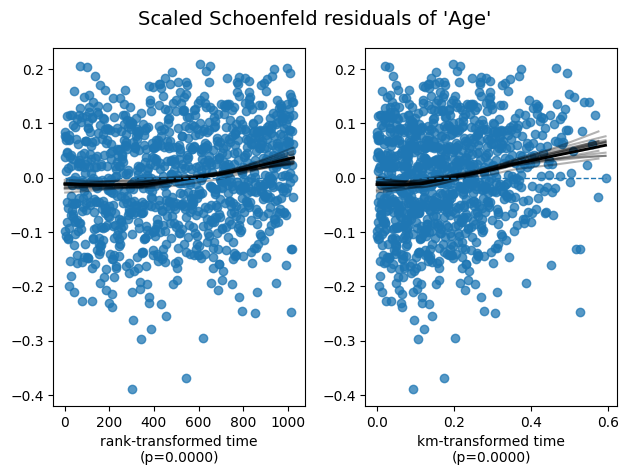

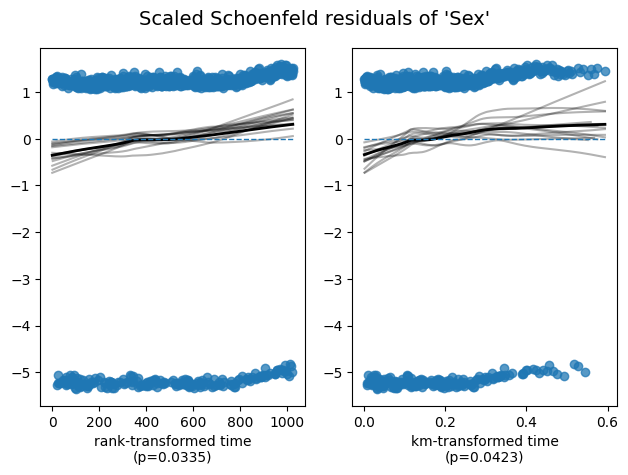

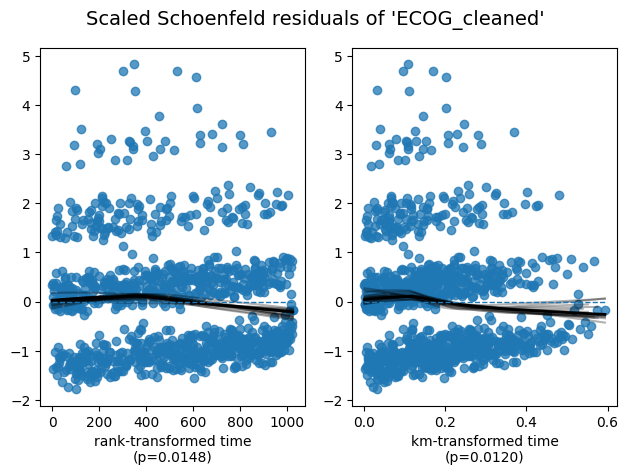

In [119]:
cph.check_assumptions(df_clean[["time", "event", "Age", "Sex", "ECOG_cleaned"]], p_value_threshold=0.05, show_plots=True)

In [122]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import train_test_split

# Step 1: Prepare survival object
y_rsf = Surv.from_dataframe("event", "time", df_clean)

# Step 2: Select features
X_rsf = df_clean[["Age", "Sex", "ECOG_cleaned", "Smoking_cleaned"]]  # feel free to add more

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X_rsf, y_rsf, test_size=0.2, random_state=42)

# Step 4: Fit the model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15,
                           max_features="sqrt", n_jobs=-1, random_state=42)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

In [123]:
from sksurv.metrics import concordance_index_censored

cindex_rsf = concordance_index_censored(y_test["event"], y_test["time"], rsf.predict(X_test))
print("RSF Concordance Index:", round(cindex_rsf[0], 3))

RSF Concordance Index: 0.702


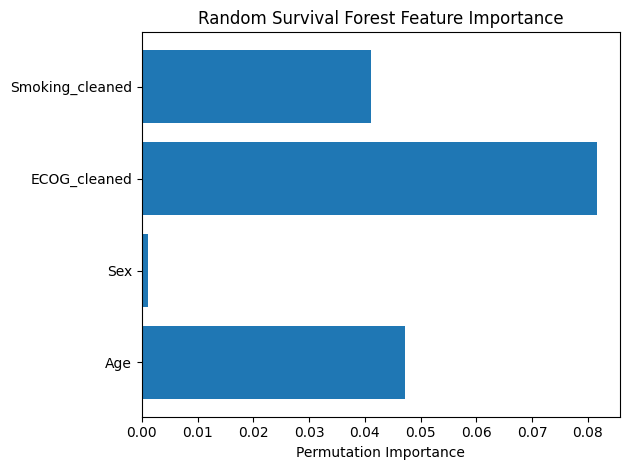

In [125]:
from sklearn.inspection import permutation_importance

# Evaluate permutation importance on test set
result = permutation_importance(
    rsf, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Extract and display importance values
importances = result.importances_mean
feature_names = X_rsf.columns

# Plot it
import matplotlib.pyplot as plt

plt.barh(feature_names, importances)
plt.xlabel("Permutation Importance")
plt.title("Random Survival Forest Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
"""A Random Survival Forest model was trained using Age, Sex, ECOG status, and
Smoking exposure as covariates. The model achieved a concordance index of 0.702,
outperforming the Cox model (C-index = 0.68). ECOG performance status was the most
predictive feature, followed by smoking exposure. The RSF model revealed that non-linear
and interaction effects may exist in the data, offering complementary insights beyond the Cox
regression model.""""
